In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 

In [2]:
mplego.style.use_latex_style()
ccycle = mplego.colors.get_default_ccycle()

In [3]:
base_path = "/storage/fits/neurocorr/exp09"

In [4]:
pvc11_1_path = os.path.join(base_path, 'exp09_1_pvc11_15_1000_1000.h5')
pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')
ret2_path = os.path.join(base_path, 'exp09_ret2_15_1000_1000.h5')
ecog_path = os.path.join(base_path, 'exp09_ecog_15_3000_1000.h5')

In [5]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
pvc11_2 = h5py.File(pvc11_2_path, 'r')
pvc11_3 = h5py.File(pvc11_3_path, 'r')
ret2 = h5py.File(ret2_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [pvc11_1, pvc11_2, pvc11_3, ret2, ecog]
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [6]:
with open(os.path.join(base_path, 'exp09_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)

with open(os.path.join(base_path, 'exp09_ncs.pkl'), 'rb') as f:
    opt_r_ncs, opt_fa_ncs, obs_ncs = pickle.load(f)

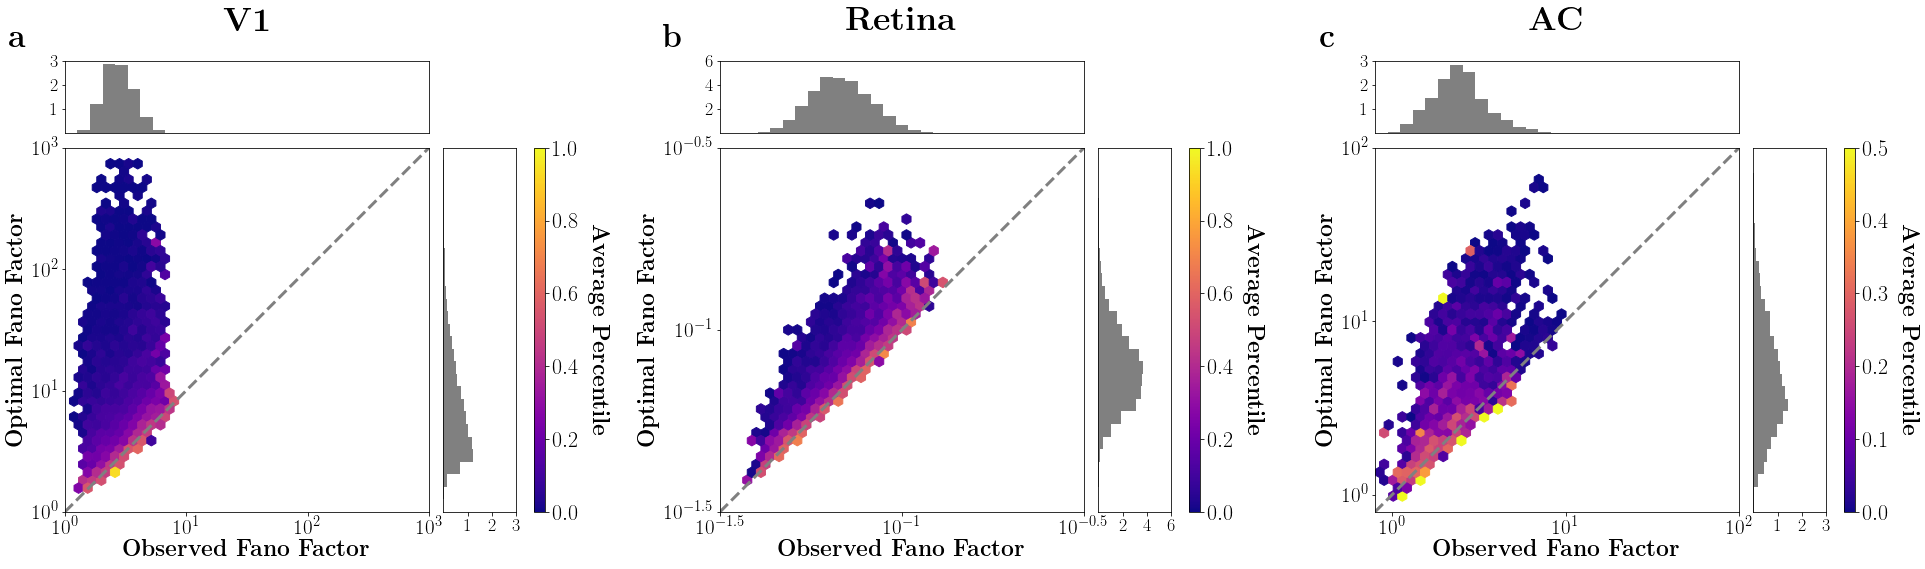

In [72]:
"""
Figure Settings
"""
# Layout settings
marginal_spacing = 0.04
marginal_width = 0.2
cb_spacing = 0.05
cb_width = 0.03
subplot_x = -0.13
subplot_y = 1.3

# Hexbin settings
gridsize = 40

# Marginal plot settings
n_bins = 30

# Font sizes
axis_label_size = 23
axis_tick_size = 21
cb_tick_size = 22
marginal_tick_size = 18
subplot_label_size = 32
title_size = 34
title_pad = 30

"""
Figure 5
"""
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
plt.subplots_adjust(wspace=0.80)

dim_idx = 0
result_idxs = [0, 3, 4]
norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=0.5)
]
extents = [
    (0, 3, 0, 3),
    (-1.5, -0.5, -1.5, -0.5),
    (-0.1, 2, -0.1, 2)
]
tops = []
sides = []

for idx, (ax, result_idx, norm, extent) in enumerate(zip(axes, result_idxs, norms, extents)):
    # Calculate relevant quantities
    log_obs_ffs = np.log10(obs_ffs[result_idx][dim_idx])
    log_opt_ffs = np.log10(opt_r_ffs[result_idx][dim_idx])
    percentiles = results[result_idx]['p_r_lfi'][dim_idx]
    # Create hexbin for comparing Fano factors
    ax.hexbin(
        log_obs_ffs,
        log_opt_ffs,
        C=percentiles,
        gridsize=gridsize,
        cmap='plasma',
        extent=extent,
        norm=norm)
    # Tighten hexbin plot
    mplego.scatter.tighten_scatter_plot(
        ax,
        lim=extent[:2],
        color='gray',
        lw=3,
        linestyle='--')
    # Create side (optimal) marginal distribution
    side_ax = mplego.axes.append_marginal_axis(
        ax,
        spacing=marginal_spacing,
        width=marginal_width,
        which='x')
    side_ax.hist(
        log_opt_ffs,
        orientation='horizontal',
        density=True,
        color='gray',
        bins=np.linspace(extent[0], extent[1], n_bins))
    side_ax.set_ylim(extent[:2])
    side_ax.set_yticks([])
    side_ax.tick_params(labelsize=marginal_tick_size)
    sides.append(side_ax)
    # Create top (observed) marginal distribution
    top_ax = mplego.axes.append_marginal_axis(
        ax,
        spacing=marginal_spacing,
        width=marginal_width,
        which='y')
    # Create side (optimal) marginal distribution
    top_ax.hist(
        log_obs_ffs,
        density=True,
        color='gray',
        bins=np.linspace(extent[0], extent[1], n_bins))
    top_ax.set_xlim(extent[:2])
    top_ax.set_xticks([])
    top_ax.tick_params(labelsize=marginal_tick_size)
    tops.append(top_ax)
    
    cax = mplego.axes.append_marginal_axis(
        ax,
        spacing=marginal_spacing + marginal_width + cb_spacing,
        width=cb_width)
    fig.colorbar(ScalarMappable(norm=norm, cmap='plasma'), cax=cax)
    cax.set_ylabel(r'\textbf{Average Percentile}', fontsize=axis_label_size, rotation=270, labelpad=30)
    cax.tick_params(labelsize=cb_tick_size)
    
    ax.set_xlabel(r'\textbf{Observed Fano Factor}', fontsize=axis_label_size)
    ax.set_ylabel(r'\textbf{Optimal Fano Factor}', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

# V1 ticks
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[0].set_yticks(axes[0].get_xticks())
axes[0].set_yticklabels(axes[0].get_xticklabels())
tops[0].set_yticks([1, 2, 3])
sides[0].set_xticks([1, 2, 3])

# Retina ticks
axes[1].set_xticks([-1.5, -1, -0.5])
axes[1].set_xticklabels([r'$10^{-1.5}$', r'$10^{-1}$', r'$10^{-0.5}$'])
axes[1].set_yticks(axes[1].get_xticks())
axes[1].set_yticklabels(axes[1].get_xticklabels())
tops[1].set_yticks([2, 4, 6])
sides[1].set_xticks([2, 4, 6])

# AC ticks
axes[2].set_xticks([0, 1, 2])
axes[2].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
axes[2].set_yticks(axes[2].get_xticks())
axes[2].set_yticklabels(axes[2].get_xticklabels())
tops[2].set_yticks([1, 2, 3])
sides[2].set_xticks([1, 2, 3])

# Apply titles
tops[0].set_title(r'\textbf{V1}', fontsize=title_size, pad=title_pad)
tops[1].set_title(r'\textbf{Retina}', fontsize=title_size, pad=title_pad)
tops[2].set_title(r'\textbf{AC}', fontsize=title_size, pad=title_pad)

# Apply subplot labels
mplego.labels.apply_subplot_labels(
    axes.ravel(),
    bold=True,
    x=subplot_x,
    y=subplot_y,
    size=subplot_label_size)

plt.savefig('figure5_ff_r.pdf', bbox_inches='tight')
plt.show()

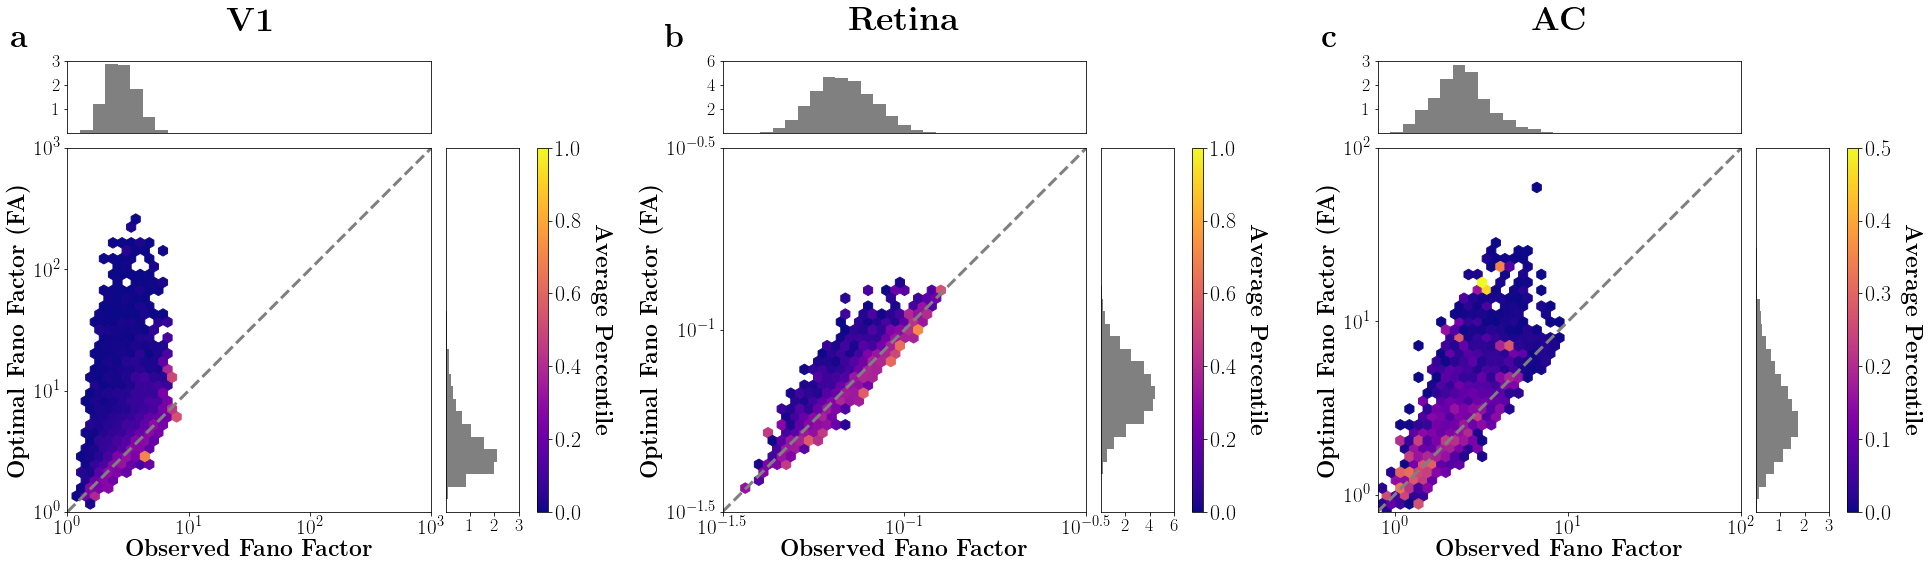

In [73]:
"""
Figure Settings
"""
# Layout settings
marginal_spacing = 0.04
marginal_width = 0.2
cb_spacing = 0.05
cb_width = 0.03
subplot_x = -0.13
subplot_y = 1.3

# Hexbin settings
gridsize = 40

# Marginal plot settings
n_bins = 30

# Font sizes
axis_label_size = 23
axis_tick_size = 21
cb_tick_size = 22
marginal_tick_size = 18
subplot_label_size = 32
title_size = 34
title_pad = 30

"""
Figure 5
"""
fig, axes = plt.subplots(1, 3, figsize=(30, 8))
plt.subplots_adjust(wspace=0.80)

dim_idx = 0
result_idxs = [0, 3, 4]
norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=0.5)
]
extents = [
    (0, 3, 0, 3),
    (-1.5, -0.5, -1.5, -0.5),
    (-0.1, 2, -0.1, 2)
]
tops = []
sides = []

for idx, (ax, result_idx, norm, extent) in enumerate(zip(axes, result_idxs, norms, extents)):
    # Calculate relevant quantities
    log_obs_ffs = np.log10(obs_ffs[result_idx][dim_idx])
    log_opt_ffs = np.log10(opt_fa_ffs[result_idx][dim_idx])
    percentiles = results[result_idx]['p_r_lfi'][dim_idx]
    # Create hexbin for comparing Fano factors
    ax.hexbin(
        log_obs_ffs,
        log_opt_ffs,
        C=percentiles,
        gridsize=gridsize,
        cmap='plasma',
        extent=extent,
        norm=norm)
    # Tighten hexbin plot
    mplego.scatter.tighten_scatter_plot(
        ax,
        lim=extent[:2],
        color='gray',
        lw=3,
        linestyle='--')
    # Create side (optimal) marginal distribution
    side_ax = mplego.axes.append_marginal_axis(
        ax,
        spacing=marginal_spacing,
        width=marginal_width,
        which='x')
    side_ax.hist(
        log_opt_ffs,
        orientation='horizontal',
        density=True,
        color='gray',
        bins=np.linspace(extent[0], extent[1], n_bins))
    side_ax.set_ylim(extent[:2])
    side_ax.set_yticks([])
    side_ax.tick_params(labelsize=marginal_tick_size)
    sides.append(side_ax)
    # Create top (observed) marginal distribution
    top_ax = mplego.axes.append_marginal_axis(
        ax,
        spacing=marginal_spacing,
        width=marginal_width,
        which='y')
    # Create side (optimal) marginal distribution
    top_ax.hist(
        log_obs_ffs,
        density=True,
        color='gray',
        bins=np.linspace(extent[0], extent[1], n_bins))
    top_ax.set_xlim(extent[:2])
    top_ax.set_xticks([])
    top_ax.tick_params(labelsize=marginal_tick_size)
    tops.append(top_ax)
    
    cax = mplego.axes.append_marginal_axis(
        ax,
        spacing=marginal_spacing + marginal_width + cb_spacing,
        width=cb_width)
    fig.colorbar(ScalarMappable(norm=norm, cmap='plasma'), cax=cax)
    cax.set_ylabel(r'\textbf{Average Percentile}', fontsize=axis_label_size, rotation=270, labelpad=30)
    cax.tick_params(labelsize=cb_tick_size)
    
    ax.set_xlabel(r'\textbf{Observed Fano Factor}', fontsize=axis_label_size)
    ax.set_ylabel(r'\textbf{Optimal Fano Factor (FA)}', fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

# V1 ticks
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[0].set_yticks(axes[0].get_xticks())
axes[0].set_yticklabels(axes[0].get_xticklabels())
tops[0].set_yticks([1, 2, 3])
sides[0].set_xticks([1, 2, 3])

# Retina ticks
axes[1].set_xticks([-1.5, -1, -0.5])
axes[1].set_xticklabels([r'$10^{-1.5}$', r'$10^{-1}$', r'$10^{-0.5}$'])
axes[1].set_yticks(axes[1].get_xticks())
axes[1].set_yticklabels(axes[1].get_xticklabels())
tops[1].set_yticks([2, 4, 6])
sides[1].set_xticks([2, 4, 6])

# AC ticks
axes[2].set_xticks([0, 1, 2])
axes[2].set_xticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
axes[2].set_yticks(axes[2].get_xticks())
axes[2].set_yticklabels(axes[2].get_xticklabels())
tops[2].set_yticks([1, 2, 3])
sides[2].set_xticks([1, 2, 3])

# Apply titles
tops[0].set_title(r'\textbf{V1}', fontsize=title_size, pad=title_pad)
tops[1].set_title(r'\textbf{Retina}', fontsize=title_size, pad=title_pad)
tops[2].set_title(r'\textbf{AC}', fontsize=title_size, pad=title_pad)

# Apply subplot labels
mplego.labels.apply_subplot_labels(
    axes.ravel(),
    bold=True,
    x=subplot_x,
    y=subplot_y,
    size=subplot_label_size)

plt.savefig('figure5_ff_fa.pdf', bbox_inches='tight')
plt.show()

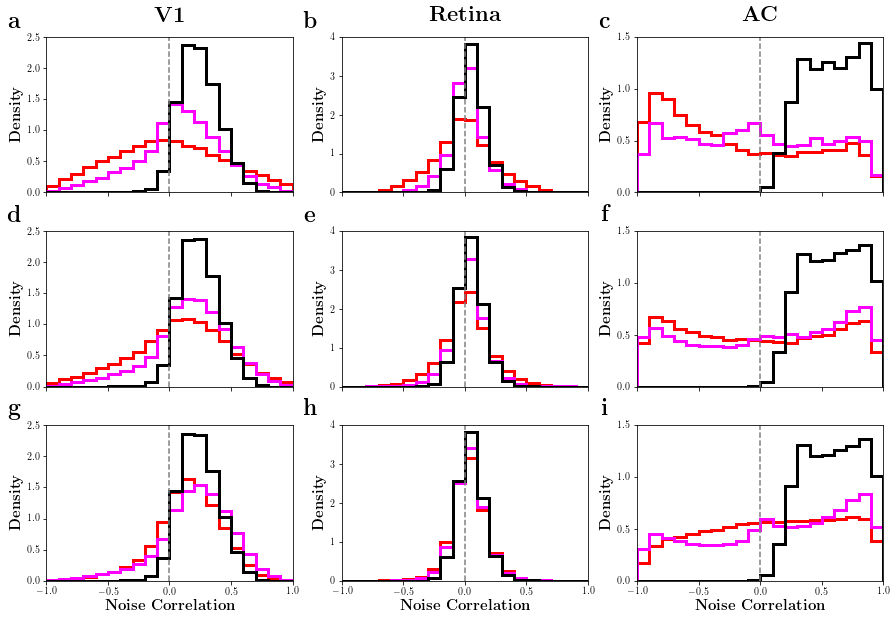

In [74]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
plt.subplots_adjust(hspace=0.25)

bins = np.linspace(-1, 1, 21)

for ii, dim in enumerate([3, 6, 15]):
    for jj, result_idx in enumerate([0, 3, 4]):
        r_ncs = opt_r_ncs[result_idx][dim].ravel()
        fa_ncs = opt_fa_ncs[result_idx][dim].ravel()
        o_ncs = obs_ncs[result_idx][dim].ravel()
        axes[ii, jj].hist(
            r_ncs,
            bins=bins,
            histtype='step',
            linewidth=3,
            color='red',
            density=True)
        axes[ii, jj].hist(
            fa_ncs,
            bins=bins,
            histtype='step',
            linewidth=3,
            color='fuchsia',
            density=True)
        axes[ii, jj].hist(
            o_ncs,
            bins=bins,
            histtype='step',
            linewidth=3,
            color='black',
            density=True)
        axes[ii, jj].set_xlim([-1, 1])
        axes[ii, jj].set_xticks([-1, -0.5, 0, 0.5, 1.0])
        axes[ii, jj].axvline(0, color='gray', linestyle='--')
        axes[ii, jj].set_ylabel(r'\textbf{Density}', fontsize=15)

for ax in axes[:, 0]:
    ax.set_ylim([0, 2.5])
    ax.set_yticks([0, 0.5, 1.0, 1.5, 2., 2.5])
for ax in axes[:, 1]:
    ax.set_ylim([0, 4])
    ax.set_yticks([0, 1, 2, 3, 4])
for ax in axes[:, 2]:
    ax.set_ylim([0, 1.5])
    ax.set_yticks([0, 0.5, 1.0, 1.5])
for ax in axes[2]:
    ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=15)

# Apply subplot labels
mplego.labels.apply_subplot_labels(
    axes.ravel(),
    bold=True,
    x=-0.13,
    y=1.10,
    size=23)

axes[0, 0].set_title(r'\textbf{V1}', fontsize=22, pad=15)
axes[0, 1].set_title(r'\textbf{Retina}', fontsize=22, pad=15)
axes[0, 2].set_title(r'\textbf{AC}', fontsize=22, pad=15)

plt.savefig('figure5_noise_corrs.pdf', bbox_inches='tight')